# Making Word Clouds from Git commits

date: TBD

<!--eofm-->

This is another re-do of [what I did in 2019](https://twitter.com/kzys/status/1080027896687673345) - making a word cloud from Git commit messages. A word cloud is a visualization which reminds me early 2008 -- the era of Web 2.0. pip has a package called [wordcloud](https://pypi.org/project/wordcloud/) which uses matplotlib. So let's install the package first and `import`.

In [93]:
! pip install wordcloud

In [94]:
import wordcloud
import matplotlib.pyplot as plt
import pandas as pd

### Collect all commit messages from a Git repository

While there may be multiple Git bindings in Python, we can just use `git log` to collect all commit messages.

In [95]:
! GIT_DIR=~/repos/github.com/rust-lang/rust/.git \
  git log --after 2018-01-01 --before 2019-01-01 --merges --format=%B > 2018.txt

In [96]:
! GIT_DIR=~/repos/github.com/rust-lang/rust/.git \
  git log --after 2019-01-01 --before 2020-01-01 --merges --format=%B > 2019.txt

The text files have all Git commit messages. Let's covert them to dataframes that have words and the number of occurences.

In [97]:
def word_freq_dataframe(file):
    content = ''
    with open(file) as f:
      content = f.read().lower()
    
    word_to_freq = {}
    for word in content.split():
        word_to_freq[word] = word_to_freq.get(word, 0) + 1
        
    records = []
    for word, freq in word_to_freq.items():
        records.append({'word':word, 'freq':freq})
    return pd.DataFrame.from_records(records).set_index(['word'])

In [98]:
word_2018 = word_freq_dataframe('2018.txt')
word_2019 = word_freq_dataframe('2019.txt')

In [99]:
df = word_2018.join(word_2019, lsuffix = '_prev')

In [100]:
df

,freq_prev,freq
word,,
auto,2069,1701.0
merge,4213,4953.0
of,7415,8770.0
#56827,1,NaN
-,7233,10081.0
...,...,...
"`repr(foo,",1,NaN
bar)`,1,NaN
"`#[repr(c,",1,2.0


The dataframe has a lot of `NaN` when one of them doesn't have corresponding words. These have to be filled before passing them to WordCloud

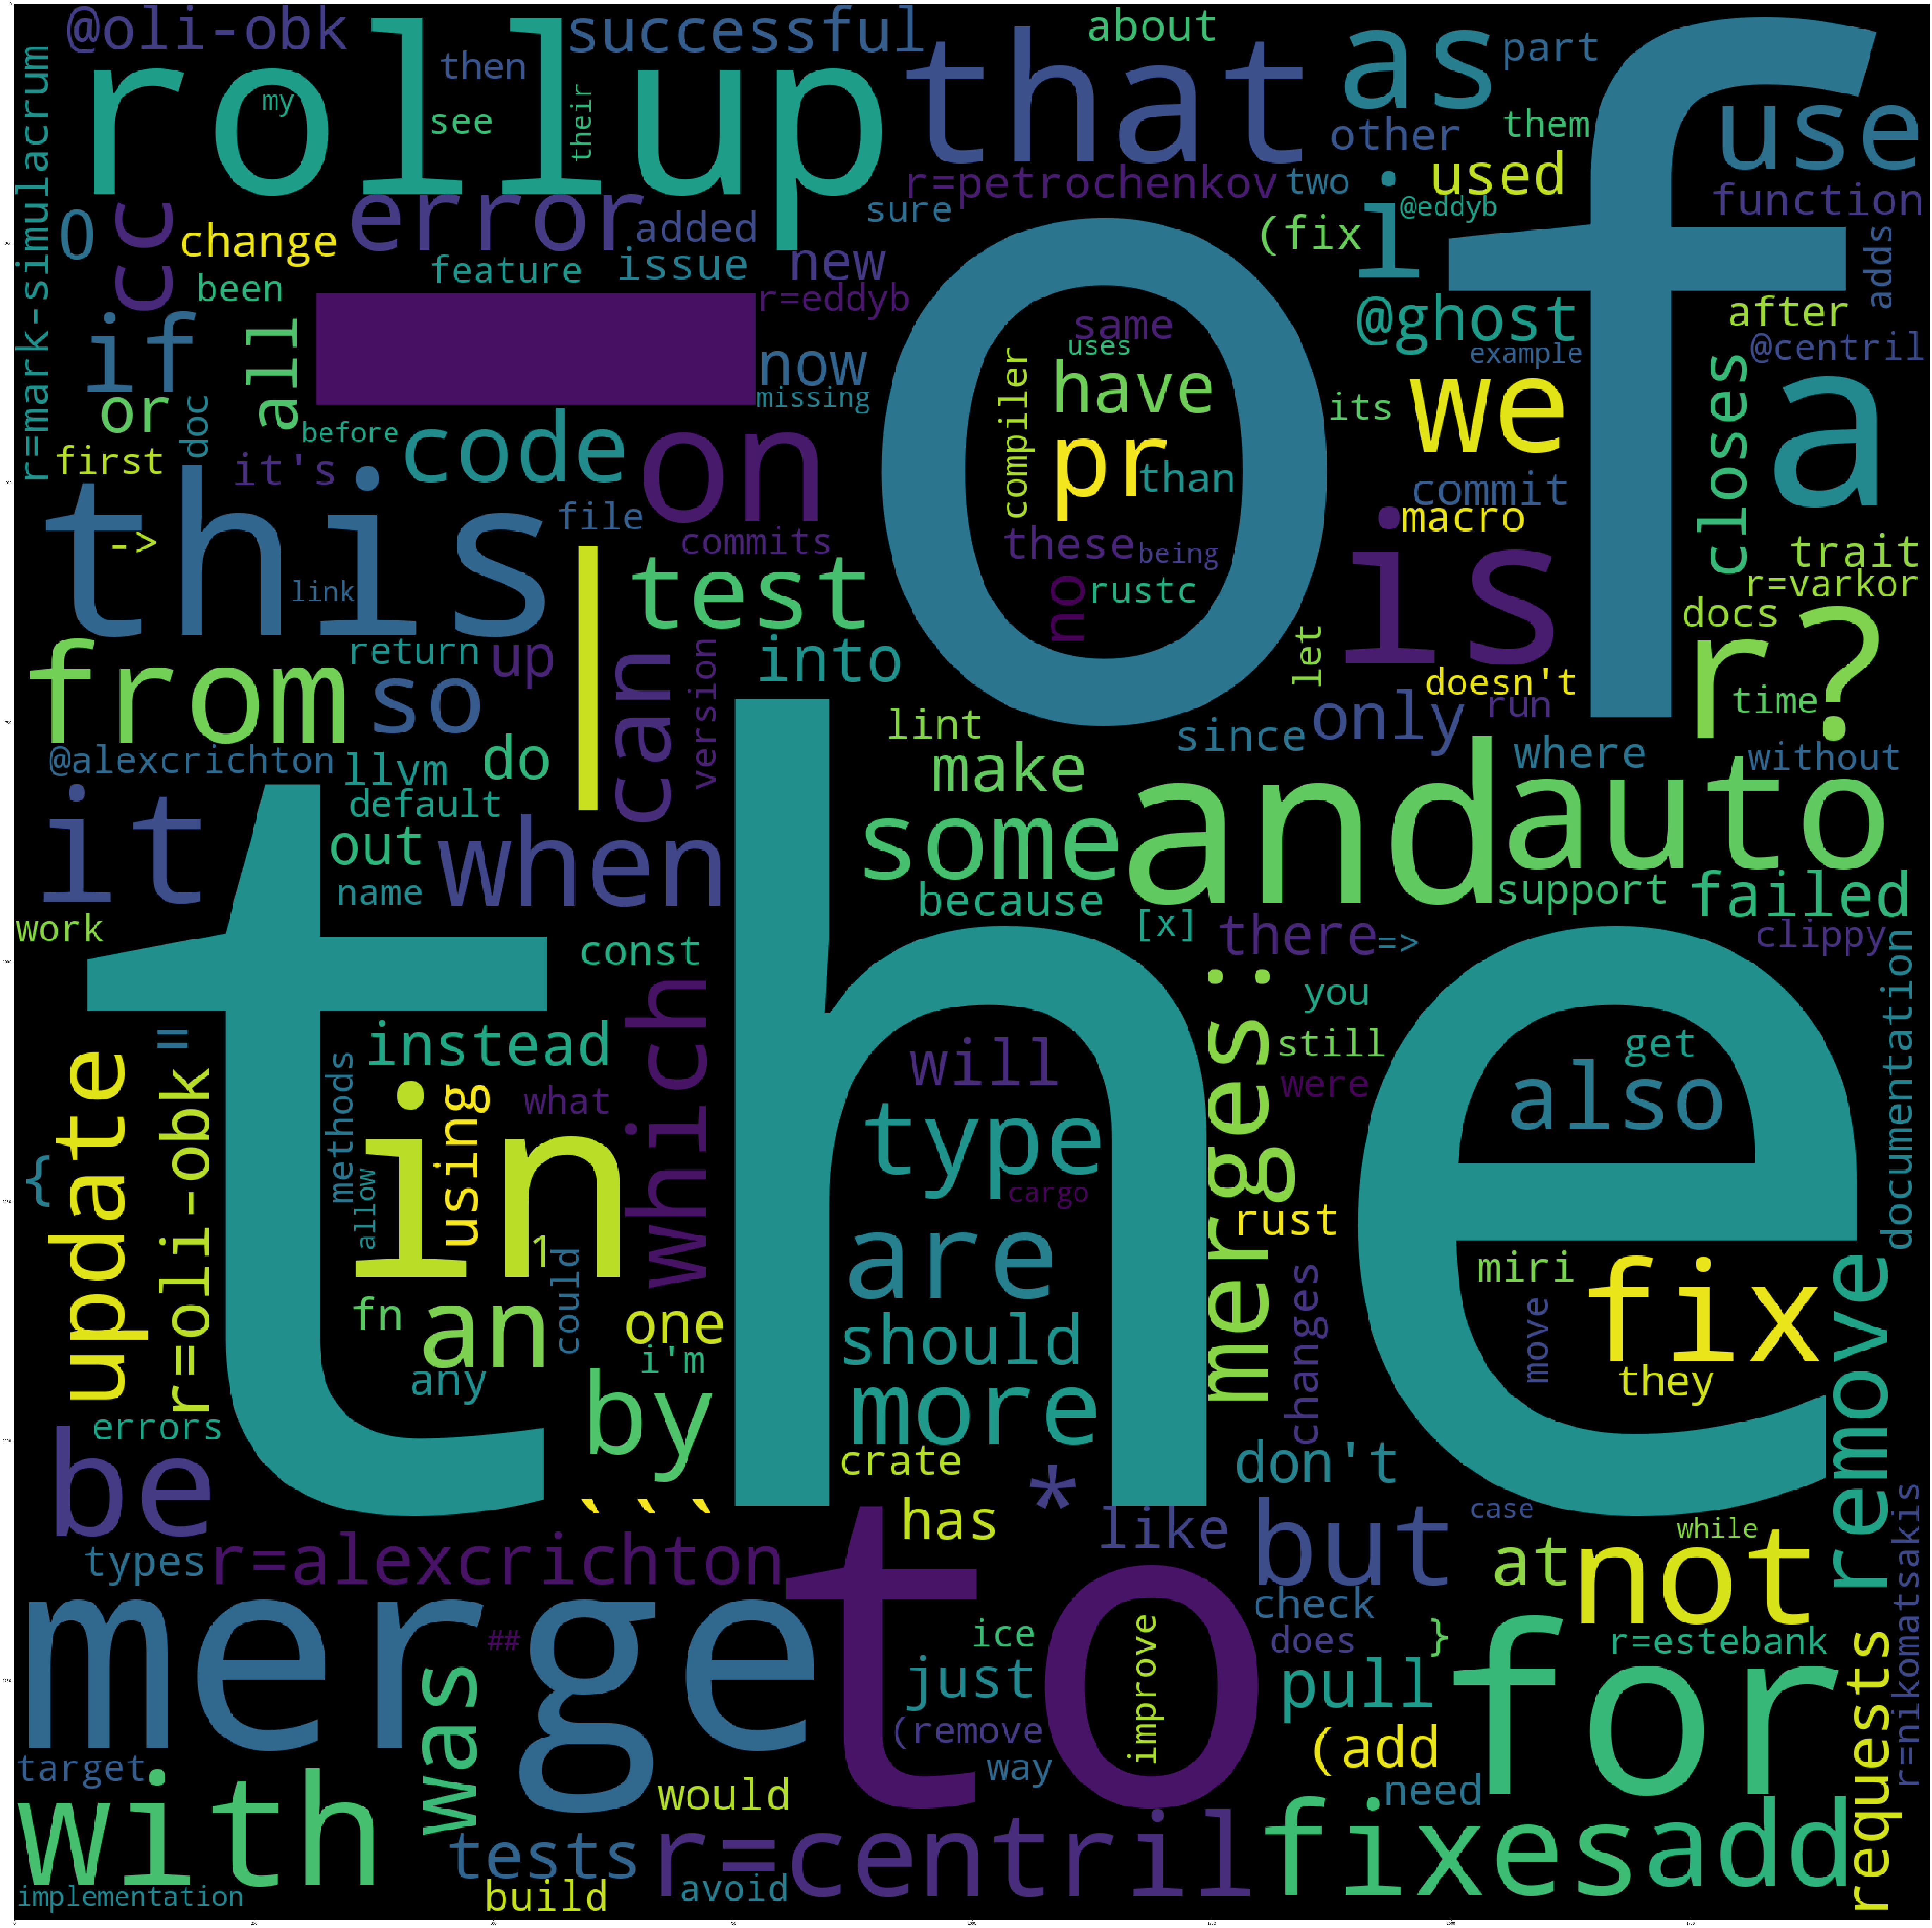

In [101]:
wc = wordcloud.WordCloud(width = 2000, height = 2000).generate_from_frequencies(df.fillna(0).to_dict()['freq'])
fig = plt.figure(figsize = (100, 100))
plt.imshow(wc)
ax = plt.show()

Now we have a word cloud, which looks ... not really interesting.

Well, there are few Git-specifc words (such as `merge`) and Rust-specific words (such as `r=login` and `rollup`) but the huge presence of `the`, `and`, `for`... makes the word cloud too noisy. It is obvious that `the` is the most commly used "word" in English. Removing them would highlight more interesting stuff.

### Noise reduction

In Natural Language Processing, these words are called "stop words". Conviniently `wordcloud` has a list of stop words, but `generate_from_frequencies` method doesn't use that. So we need to manually convert the list to a dataframe, joinining it to what we have.

In [102]:
wordcloud.STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

In [103]:
def create_stopwords_dataframe(words):
    records = []
    for word in words:
        records.append({'word':word, 'is_stopword':True})
    return pd.DataFrame.from_records(records).set_index(['word'])
df = df.join(create_stopwords_dataframe(wordcloud.STOPWORDS)).fillna(value = {'is_stopword':False})

In [104]:
df[df.is_stopword==False]

,freq_prev,freq,is_stopword
word,,,
auto,2069,1701.0,False
merge,4213,4953.0,False
#56827,1,NaN,False
-,7233,10081.0,False
"faern:eliminate-recv-timeout-panic,",1,NaN,False
...,...,...,...
"`repr(foo,",1,NaN,False
bar)`,1,NaN,False
"`#[repr(c,",1,2.0,False


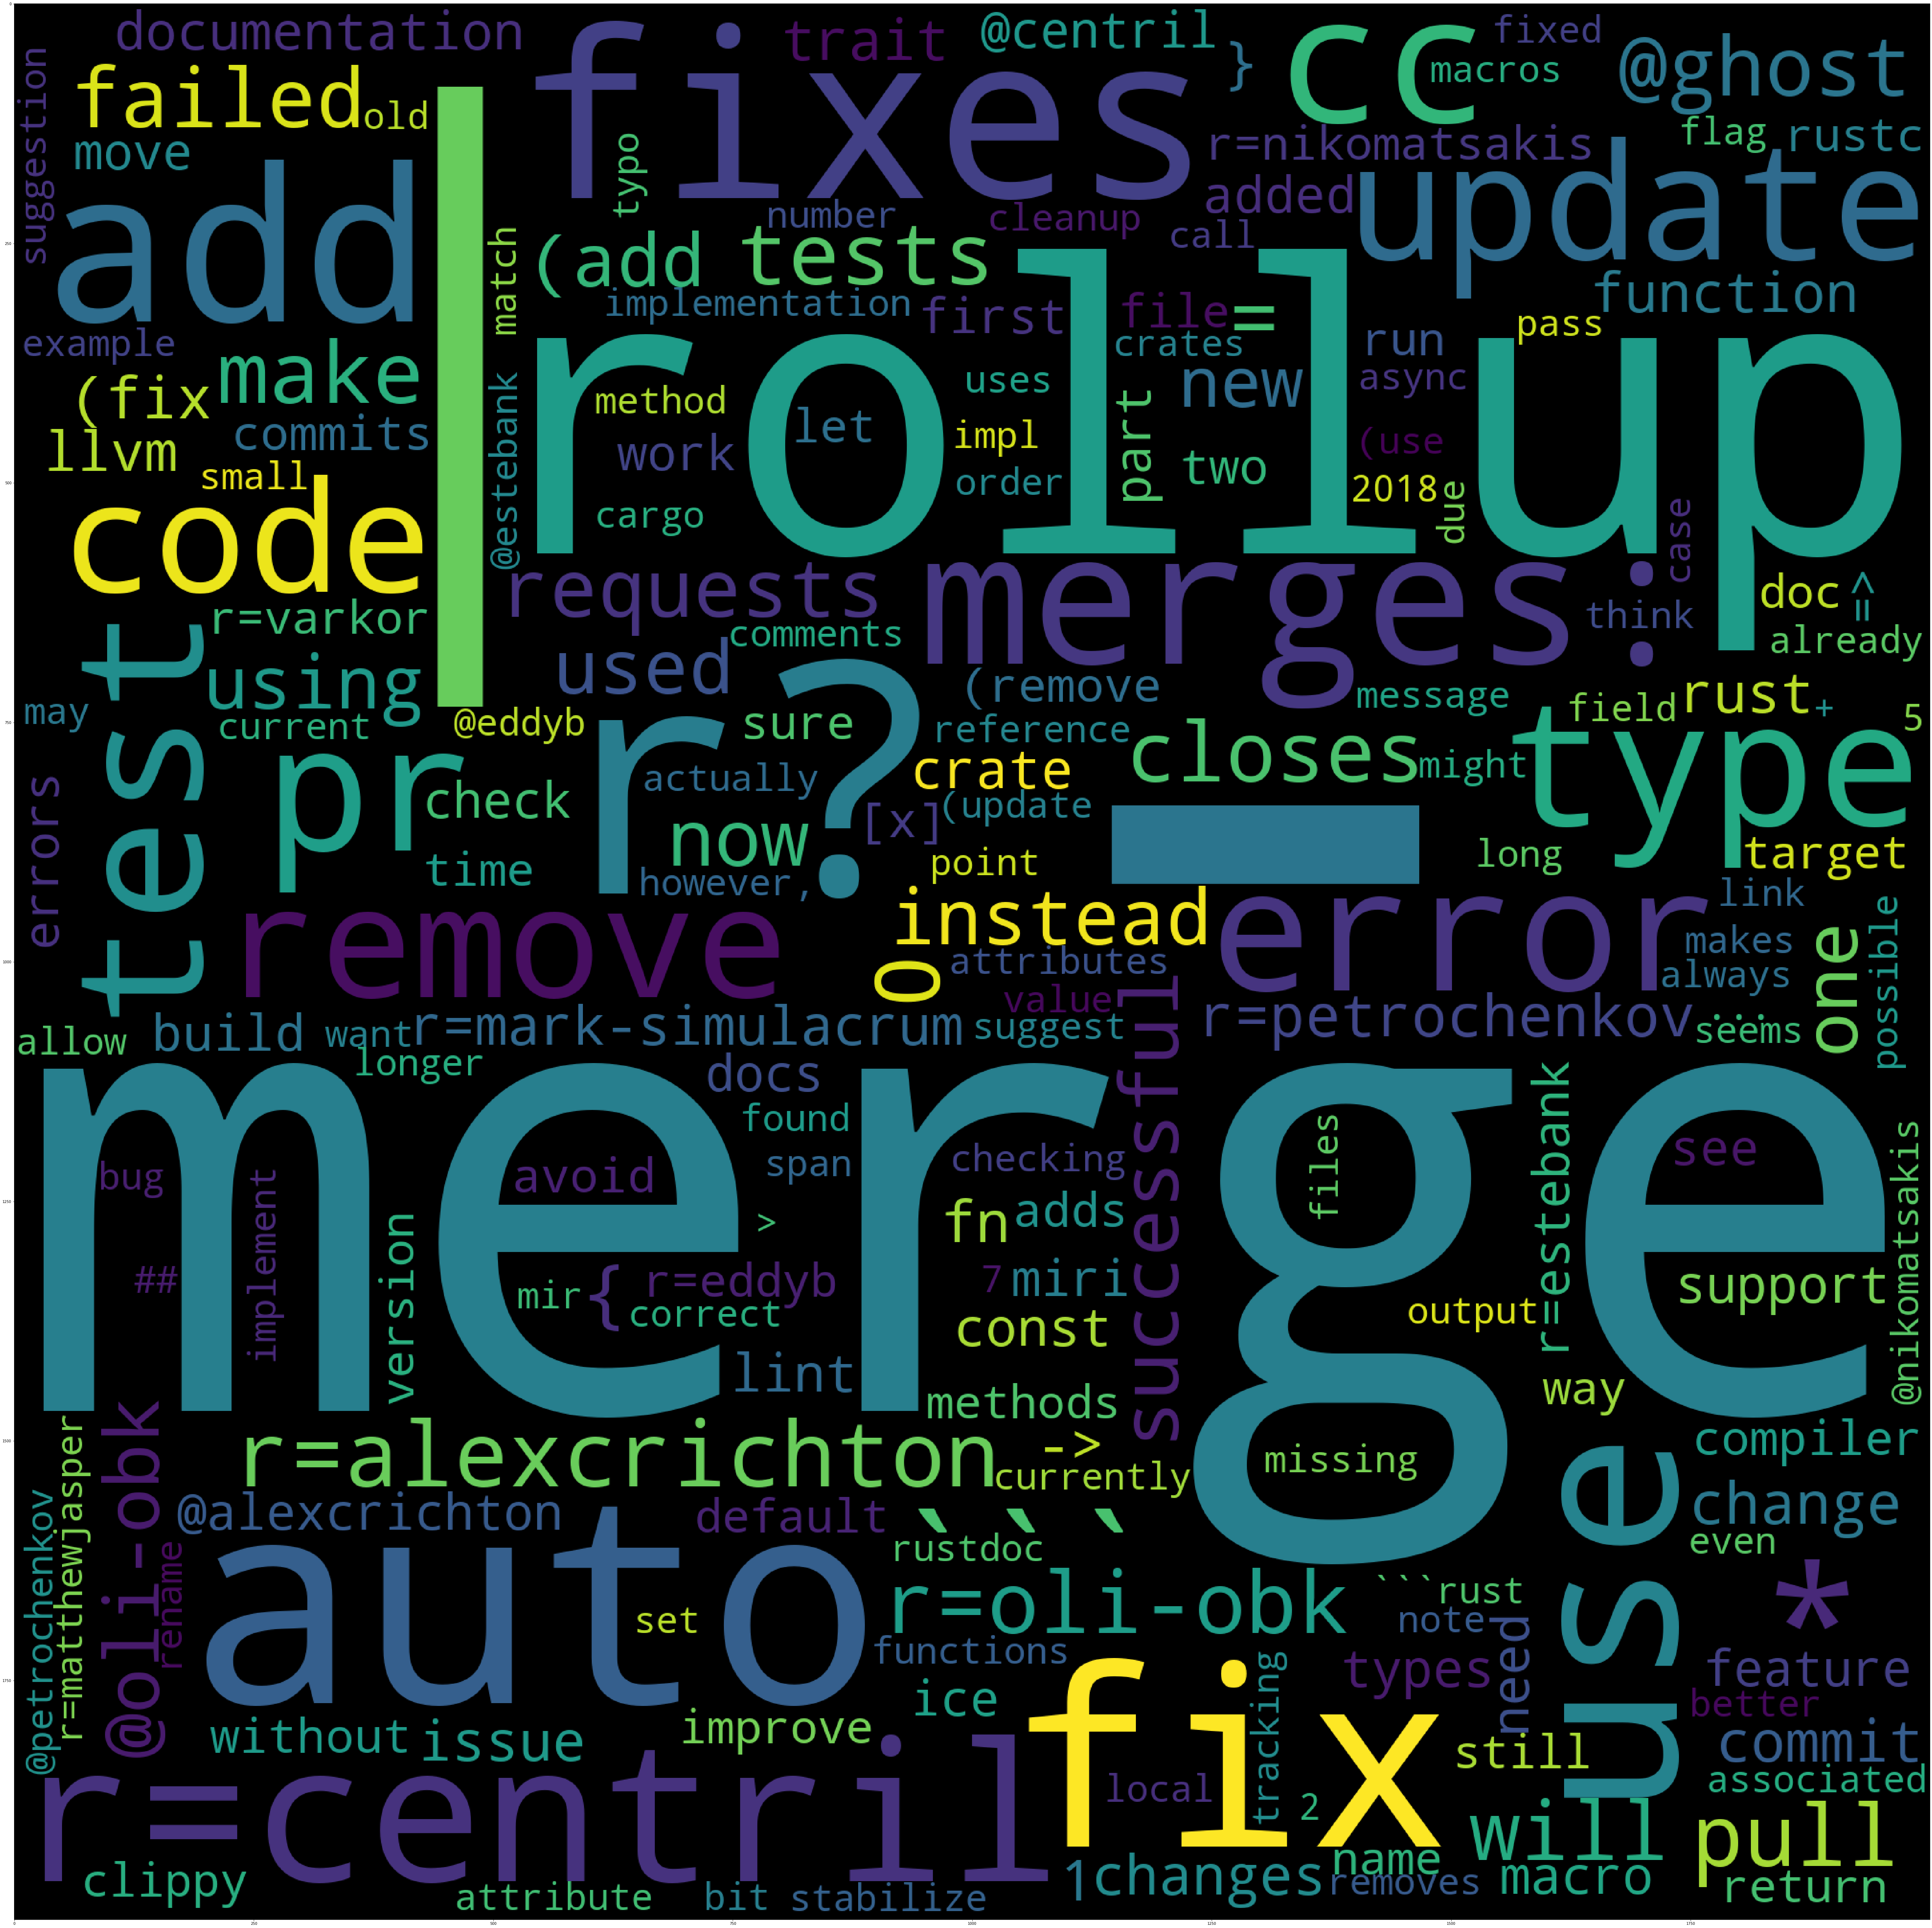

In [105]:
wc = wordcloud.WordCloud(width = 2000, height = 2000).generate_from_frequencies(df[df.is_stopword==False].fillna(0).to_dict()['freq'])
fig = plt.figure(figsize = (100, 100))
plt.imshow(wc)
ax = plt.show()

This looks better.

In [106]:
df.sort_values('freq')

,freq_prev,freq,is_stopword
word,,,
#54252,1,1.0,False
interacts,1,1.0,False
(detect,3,1.0,False
std::fmt:,2,1.0,False
disabled.,4,1.0,False
...,...,...,...
"hints""",1,NaN,False
"`repr(foo,",1,NaN,False
bar)`,1,NaN,False


In [107]:
wordcloud = WordCloud(
    width = 2000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).fit_words(df.to_dict()['freq'])

ValueError: cannot convert float NaN to integer

In [ ]:
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
ax = plt.show()

In [ ]:
df

In [ ]:
df['delta_ratio'] = df.freq_prev / df.freq
df['delta_sub'] = df.freq_prev - df.freq
df['delta_sub_abs'] = (df.freq_prev - df.freq).abs()
#df['delta_i'] = (1.0 - (df.freq_2018 / df.freq_2017)).abs()
df['sum'] = df.freq_prev + df.freq

In [ ]:
df.sort_values('delta_ratio')

In [108]:
wc = WordCloud(
    width = 2000,
    height = 2000,
    background_color = 'white').generate_from_frequencies(df.to_dict()['freq'])
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
ax = plt.show()

ValueError: cannot convert float NaN to integer